# Emulating $\xi_+$-$\xi_-$-clustering covariances

The "key project" in DES is the combined probes analysis. For DES Y1, this was the 3x2pt analysis, which consisted of three 2-point functions (hence the name). There was used a corresponding covariance matrix between these probes. In this notebook, we will build an emulator for just the $\xi_+$-$\xi_-$-clustering ($w(\theta)$) covariance from a set of 25 covariances computed by Tim Eifler in a 10 dimensional parameter space (cosmology + 5 tomographic biases).

In [1]:
import numpy as np
from scipy import stats
import covariance_emulator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rc("font", size=14, family="serif")
#plt.rc("text", usetex=True)

In [3]:
#Read in the domain locations, or locations in parameter space
parameters = np.loadtxt("cosmo_parameters.txt")
print(parameters.shape)

(25, 10)


In [4]:
#Load in the covariances
covs = np.load("gaussian_xipgammaw_sub_covs_withcut.npy")
print(covs.shape)

(25, 337, 337)


In [5]:
#View the correlation matrix of the first
def corr_from_cov(cov):
    D = np.diag(np.sqrt(cov.diagonal()))
    Di = np.linalg.inv(D)
    return np.dot(Di, np.dot(cov, Di))

def view_corr(cov, lncov=False):
    R = corr_from_cov(cov)
    fig, ax = plt.subplots()
    if lncov:
        R = np.log(np.fabs(cov))
    im = ax.imshow(R, interpolation="nearest", origin="lower")
    plt.colorbar(im)
    return

In [6]:
#Split off the last covariance matrix
test_cov = covs[-1]
test_parameters = parameters[-1]
covs = covs[:-1]
parameters = parameters[:-1]

1.651153e+08


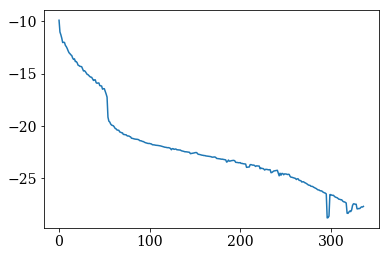

In [7]:
w, v = np.linalg.eig(test_cov)
print("%e"%(max(w)/min(w)))
plt.plot(np.log(w))

1.543649e+08


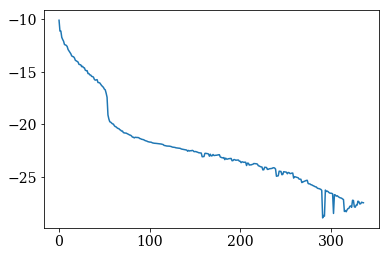

In [8]:
#Create an emulator
NPC_D = 10
NPC_L = 10
Emu = covariance_emulator.CovEmu(parameters, covs, NPC_D=NPC_D, NPC_L=NPC_L)
Cpredicted = Emu.predict(test_parameters)
w, v = np.linalg.eig(Cpredicted)
print("%e"%(max(w)/min(w)))
plt.plot(np.log(w))

## Finding an optimal emulator

The covariance emulator built above was done with the default configuration with a few principle components, but it actually has a few knobs to turn. We can control not only the number of principle components for D and L (`NPC_D, NPC_L`), but we can also create and pass in `george` kernels for both `D` and `L`. In the next cell, we will look over all reasonable options, and figure out which emulator setup is the best (but we keep the number of principle components fixed for now).

Our method is the following:
1. Take the test covariance matrix $C_{\rm true}$ and draw from a multivariate normal in order to obtain a realization of the noise $d$.
2. Compute $\chi^2 = d^TC_{\rm emu}^{-1}d$ using the inverse of the emulated covariance matrix.
3. Repeat steps 1-2 thousands of times, recording all $\chi^2$s.
4. Histogram the $\chi^2$ values and plot them against the expected distribution given the number of degrees of freedom.

In [9]:
#Given a covariance matrix, make realizations of the noise, and then find the optimal kernel set up
def best_kernel_for_C(C, N_samples=1000):
    dof = len(C)
    means = np.zeros(dof)
    chi2s = np.zeros(N_samples)
    noise_realizations = np.array([np.random.multivariate_normal(means, C) for i in range(N_samples)])
    import george.kernels as kernels
    kerns = [kernels.ExpSquaredKernel]#, kernels.Matern52Kernel, kernels.Matern32Kernel]
    names = ["Exp2"]#, "Mat52", "Mat32"]
    Npars = len(parameters[0])
    metric_guess = 4.#np.std(parameters, 0)
    #Loop over kernel combinations and compute the chi2 shift
    best_shift = 1e99
    best_kernels = None
    for nameD, kd in zip(names, kerns):
        kernel_D = kd(metric=metric_guess, ndim=Npars)
        for nameL, kl in zip(names, kerns):
            kernel_L = kl(metric=metric_guess, ndim=Npars)
            Emu = covariance_emulator.CovEmu(parameters, covs, NPC_D=NPC_D, NPC_L=NPC_L, 
                                             kernel_D = kernel_D, kernel_lp = kernel_L)
            shift = 0
            try:
                Cpredicted = Emu.predict(test_parameters)
                iCpredicted = np.linalg.inv(Cpredicted)
            except np.linalg.LinAlgError:
                shift = 1e99
            else:
                for i in range(N_samples):
                    chi2s[i] = np.dot(noise_realizations[i], np.dot(iCpredicted, noise_realizations[i]))
                    shift = np.mean(chi2s) - dof
            if shift < best_shift and shift > 0:
                best_shift = shift
                best_name = "%s %s"%(nameD, nameL)
                best_kernels = [kernel_D, kernel_L]
            print("%s %s: %e / %d"%(nameD, nameL, shift, dof))
    print("Best combination: %s"%best_name)
    print("\tshift/dof = %e / %d"%(best_shift, dof))
    return best_kernels

In [10]:
best_kernels = best_kernel_for_C(test_cov)

Exp2 Exp2: 3.875659e+00 / 337
Best combination: Exp2 Exp2
	shift/dof = 3.875659e+00 / 337


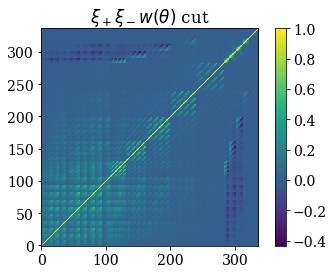

In [11]:
#Let's visualize
kernel_D, kernel_L = best_kernels
#kernel_L = 1.*kernels.Matern32Kernel(metric=metric_guess, ndim=Npars)
Emu = covariance_emulator.CovEmu(parameters, covs, NPC_D=NPC_D, NPC_L=NPC_L, 
                                 kernel_D = kernel_D, kernel_lp = kernel_L)
Cpredicted = Emu.predict(test_parameters)
view_corr(Cpredicted)
plt.title(r"$\xi_+\xi_-w(\theta)$ cut")
#plt.savefig("predicted_cov.png", dpi=300, bbox_inches="tight")

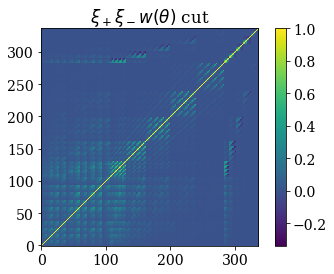

In [12]:
view_corr(test_cov)
plt.title(r"$\xi_+\xi_-w(\theta)$ cut")
#plt.savefig("true_cov.png", dpi=300, bbox_inches="tight")

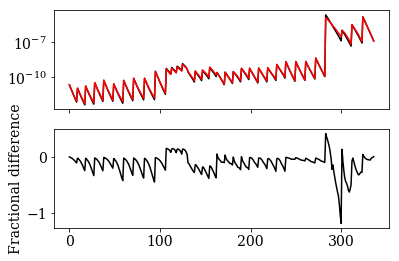

In [13]:
true_var = test_cov.diagonal()
emu_var = Cpredicted.diagonal()
frac_diff = (true_var - emu_var) / true_var

fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].plot(true_var, c='k', label='True variance')
ax[0].plot(emu_var, c='r', label='Emulated variance')
ax[1].plot(frac_diff, c='k')
ax[0].set_yscale('log')
ax[1].set_ylabel(r"Fractional difference")
#ax[1].set_ylim(-2.5, 2.5)

## Assessing the emulator performance

One of the best ways to assess the performance of the emulator is to directly compare the true covariance to the emulated covariance. In the next cell, I will draw realizations of the noise from the true covariance, and compute $\chi^2$ values of these noises compared agains the emulated covariance. Then, by checking this against the expected distribution, we can see the performance of the emulator.

In [14]:
#Define a function where we input two covariances, and get back out a list of chi2s
def get_chi2s_between_Cs(C1, C2, N_samples=1000):
    means = np.zeros(len(C1))
    chi2s = np.zeros(N_samples)
    iC2 = np.linalg.inv(C2)
    for i in range(N_samples):
        x = np.random.multivariate_normal(means, C1)
        chi2s[i] = np.dot(x, np.dot(iC2, x))
    return chi2s

dof = len(test_cov)

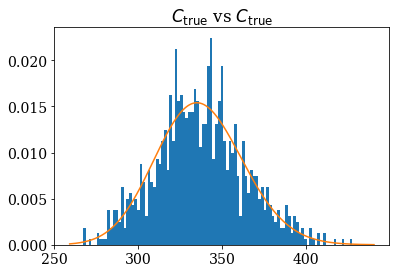

In [15]:
chi2s = get_chi2s_between_Cs(test_cov, test_cov)
plt.hist(chi2s, normed=True, bins=100)
x = np.linspace(min(chi2s)*0.97, 1.03*max(chi2s), 1000)
plt.plot(x, stats.chi2.pdf(x, dof))
plt.title(r"$C_{\rm true}$ vs $C_{\rm true}$")

In [22]:
chi2s = get_chi2s_between_Cs(test_cov, Cpredicted, 10000)

Chi2/dof shift = 4.16 / 337


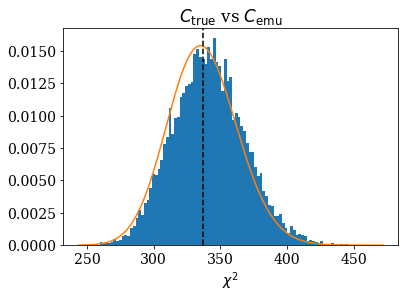

In [23]:
plt.hist(chi2s, normed=True, bins=100)
x = np.linspace(min(chi2s)*0.97, 1.03*max(chi2s), 1000)
#x = np.linspace(300, 800, 1000)
plt.plot(x, stats.chi2.pdf(x, dof))
plt.title(r"$C_{\rm true}$ vs $C_{\rm emu}$")
plt.xlabel(r"$\chi^2$")
plt.axvline(dof, color="k", ls="--")
ax = plt.gca()
#ax.text(0.7, 0.5, r"$\chi2=d^TC^{-1}d$", transform=ax.transAxes)
print("Chi2/dof shift = %.2f / %d"%(np.mean(chi2s) - dof, dof))
plt.savefig("chi2_realizations.png", dpi=300, bbox_inches="tight")

# Emulated covariance vs. any random covariance

In fiducial analyses, and as has been suggested in the literature, we should be "fine" with neglecting parameter dependence in the covariance matrix. We can test this easily, by doing the chi2 distribution comparison between the test covariance matrix and the covariances we have on hand.

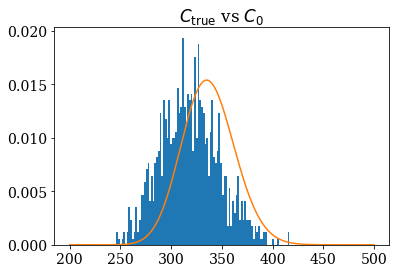

In [20]:
chi2s = get_chi2s_between_Cs(test_cov, covs[0])
plt.hist(chi2s, normed=True, bins=100)
x = np.linspace(200, 500, 1000)
plt.plot(x, stats.chi2.pdf(x, dof))
plt.title(r"$C_{\rm true}$ vs $C_{\rm 0}$")

Chi2/dof shift = -17.26 / 337
Chi2/dof shift = -17.90 / 337
Chi2/dof shift = -16.98 / 337


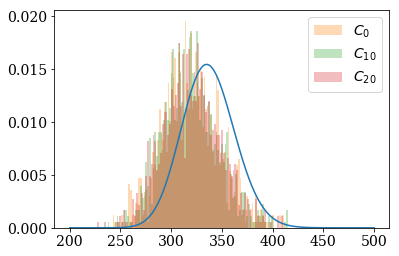

In [21]:
#Try looping over a few and comparing
x = np.linspace(200, 500, 1000)
#x = np.linspace(90, 300, 1000)
plt.plot(x, stats.chi2.pdf(x, dof))

for i in [0, 10, 20]:
    chi2s = get_chi2s_between_Cs(test_cov, covs[0], 1000)
    plt.hist(chi2s, normed=True, bins=100, alpha=0.3, label=r"$C_{%d}$"%i)
    print("Chi2/dof shift = %.2f / %d"%(np.mean(chi2s) - dof, dof))
plt.legend()

We can see that for 200 degrees of freedom, using any old covariance matrix can shift $chi^2$ by about 28/200, while just using the emulator is essentially perfect. Thus, it is a clear improvement.